In [1]:
import numpy as np
import mrcfile
from matplotlib import pyplot as plt
%matplotlib inline
import collections
import tensorflow as tf
from tensorflow import spectral
from ClassFiles.relion_fixed_it import load_star
from ClassFiles.AdversarialRegularizer import AdversarialRegulariser
from ClassFiles.ut import l2
from ClassFiles.Utilities import registration
from ClassFiles.ut import locate_gt, rfft, irfft, unify_form, Rescaler

In [108]:
base_path = '/local/scratch/public/sl767/MRC_Data/Data_002_10k/EM/'
#path=base_path+'Refine3D/1H12/1H12_mult002_it007_half2_class001_external_reconstruct.star'
#path=base_path+'Refine3D/1H12/1H12_mult005_it001_half1_class001_external_reconstruct.star'
path=base_path+'9ICA/9ICA_mult002_it001_half2_class001_external_reconstruct.star'
# sgd_path='/local/scratch/public/sl767/MRC_Data/Data_002_10k/SGD/1O20/1O20_mult002_it300_class001.mrc'

pdb = '9ICA'
ground_truth_path=locate_gt(pdb)

In [109]:
file=load_star(path)

In [110]:
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataReal']) as mrc:
    data_real = mrc.data
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataImag']) as mrc:
    data_im = mrc.data
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsWeight']) as mrc:
    kernel = mrc.data
with mrcfile.open(ground_truth_path) as mrc:
    ground_truth = mrc.data
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsResult']) as mrc:
    naive_recon = mrc.data
# with mrcfile.open(path) as mrc:
#     sgd_res = mrc.data
# with mrcfile.open(sgd_path) as mrc:
#    sgd_data = mrc.data

ground_truth = unify_form(ground_truth)
r_gt = Rescaler(ground_truth)
r_gt.normalize(ground_truth)

In [111]:
complex_data=data_real + 1j * data_im

In [112]:
REGULARIZATION=.001
set_off=REGULARIZATION*kernel.max()
reg_kernel = kernel+set_off

In [113]:
# Initial guess for iterative algorithm
reco = np.divide(complex_data,reg_kernel)
ini = np.copy(reco)
# reco = np.fft.rfftn(np.fft.ifftshift(sgd_data))
# ini = np.copy(reco)
reco_real = irfft(reco)

In [114]:
print(np.max(kernel))

1.93852e+08


Build visualization tool

In [115]:
def vis(data, fourier=True):
    if fourier:
        data = irfft(data)
    #plt.imshow(im[...,45])
    plt.imshow(np.mean(data.squeeze(), axis=-1))

In [116]:
ground_truth.shape

(1, 96, 96, 96, 1)

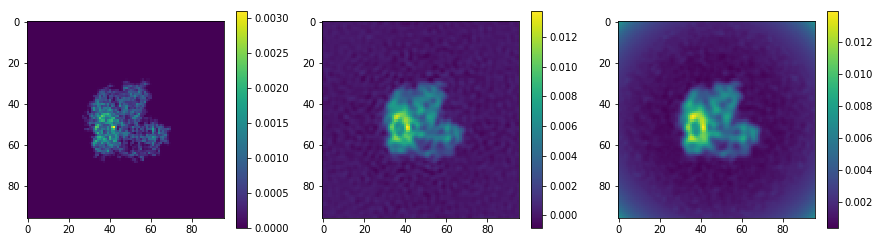

In [117]:
naive_recon_cut=np.maximum(naive_recon,0)
plt.figure(figsize=(15,4))
plt.subplot(131)
vis(ground_truth, fourier=False)
plt.colorbar()
plt.subplot(132)
vis(reco_real, fourier=False)
plt.colorbar()
plt.subplot(133)
vis(naive_recon_cut, fourier=False)
plt.colorbar()

In [52]:
def full_eval(x, pdb, fourier_input=True):
    if fourier_input:
        x = irfft(x)
    with mrcfile.open(locate_gt(pdb)) as mrc:
        ground_truth = mrc.data
    ground_truth = unify_form(ground_truth)
    
    # Normalization
    r1 = Rescaler(ground_truth)
    r1.normalize(ground_truth)
    r2 = Rescaler(x)
    r2.normalize(x)
    
    # register the ground truth towards
    registered = Registrator.register(image=x, reference=ground_truth)
    print('Initial L2: {}'.format(l2(registered-ground_truth)))
    
    # perform a step of EM
    r2.scale_up(registered)
    fsc, acc_rot, path_oneEM = oneStepEM(registered.squeeze(), pdb)
    with mrcfile.open(path_oneEM) as mrc:
        new_recon = mrc.data
    new_recon = unify_form(new_recon)
    
    r3 = Rescaler(new_recon)
    r3.normalize(new_recon)
    
    reg = Registrator.register(image=new_recon, reference=ground_truth)
    print('Posterior L2: {}'.format(l2(reg - ground_truth)))
    print('Angular Spread: {}'.format(acc_rot))

In [53]:
# reco_real = unify_form(reco_real)
# full_eval(reco_real, pdb, fourier_input=False)

In [54]:
# with mrcfile.open(locate_gt(pdb)) as mrc:
#     ground_truth = mrc.data
# ground_truth = unify_form(ground_truth)

# reco_real = unify_form(reco_real)

# # Normalization
# r1 = Rescaler(ground_truth)
# r1.normalize(ground_truth)
# r2 = Rescaler(reco_real)
# r2.normalize(reco_real)

# # register the ground truth towards
# registered = Registrator.register(image=reco_real, reference=ground_truth)
# print('Initial L2: {}'.format(l2(registered-ground_truth)))

# # perform a step of EM
# r2.scale_up(registered)
# print(l2(registered))
# print(l2(naive_recon))
# print(l2(registered.squeeze()-naive_recon))
# fsc, acc_rot, path_oneEM = oneStepEM(registered.squeeze(), pdb)
# with mrcfile.open(path_oneEM) as mrc:
#     new_recon = mrc.data
# new_recon = unify_form(new_recon)
# r3 = Rescaler(new_recon)
# r3.normalize(new_recon)

# reg = Registrator.register(image=new_recon, reference=ground_truth)
# print('Posterior L2: {}'.format(l2(reg - ground_truth)))
# print('Angular Spread: {}'.format(acc_rot))

In [55]:
saves_path = '/local/scratch/public/sl767/SPA/Saves/Adversarial_Regulariser/SGD_Trained/phase_augmentation/'
regularizer = AdversarialRegulariser(saves_path)

INFO:tensorflow:Restoring parameters from /local/scratch/public/sl767/SPA/Saves/Adversarial_Regulariser/SGD_Trained/phase_augmentation//Data/model-5000
Save restored


In [56]:
Registrator = registration.LocalRegistrator()

/alt/applic/user-maint/sl767/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [57]:
STEP_SIZE=5e4
def grad(image):
    grad = regularizer.evaluate(image)
    return grad

In [ ]:
# plt.subplot(131)
# vis(ini)
# plt.subplot(132)
# gradient = grad(reco)
# vis(gradient)
# reco=reco-STEP_SIZE*(gradient-9.0675324549243569e-07*ini)
# plt.subplot(133)
# vis(reco)

In [ ]:
# for k in range(500):
#     STEP_SIZE=1e-2
#     gradient = grad(reco)
#     reco = reco - STEP_SIZE*(gradient*(96**3)+7*(reco-ini))
#     if k%50==0:
#         plt.figure(k)
#         plt.subplot(121)
#         vis(reco)
#         plt.subplot(122)
#         vis(ini)
#         plt.show()

In [58]:
def l2_gt(x):
    image=unify_form(np.copy(x))
    r=Rescaler(image)
    r.normalize(image)
    reg=Registrator.register(image=image, reference=ground_truth)
    return l2(reg-ground_truth)

def turn_gt(sgd):
    image=np.copy(x)
    r=Rescaler(image)
    r.normalize(image)
    return Registrator.register(image=ground_truth, reference=image)

In [59]:
def get_coordinate_change(power=1.0, cutoff=100.0):
    print(cutoff)
    print(power)
    X, Y, Z = np.meshgrid(np.linspace(-1, 1, 96),
                          np.linspace(-1, 1, 96),
                          np.linspace(-1, 1, 96))

    R = np.sqrt(X ** 2 + Y ** 2 + Z ** 2)
    R = np.fft.fftshift(R)[:,:,:49]
    
    R = 1 / R ** power
    R = np.minimum(R, cutoff * np.min(R))
    R = R / np.max(R)
    return R

1000.0
1.0


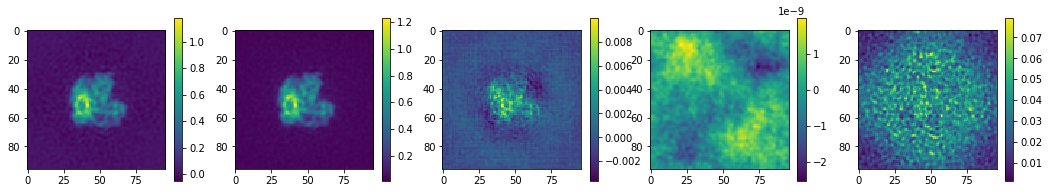

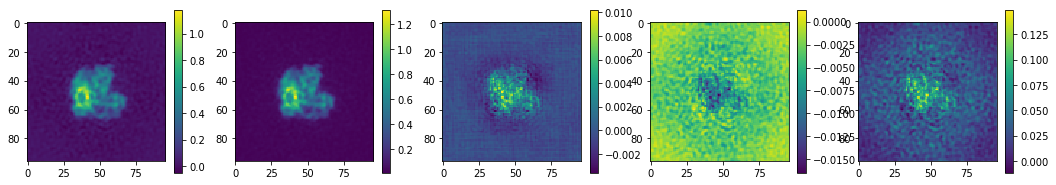

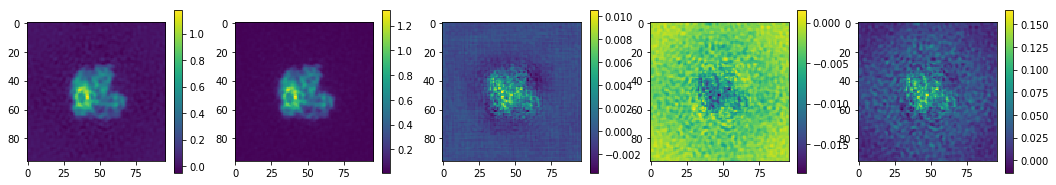

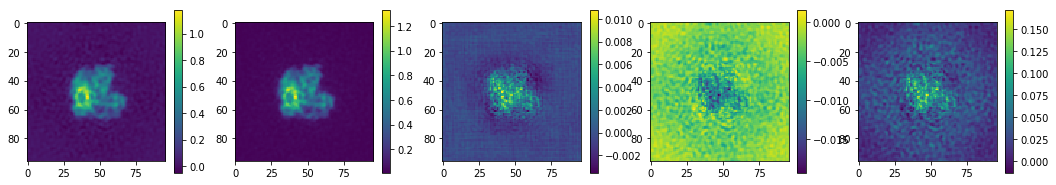

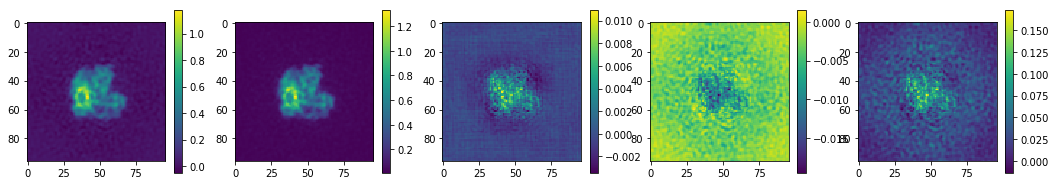

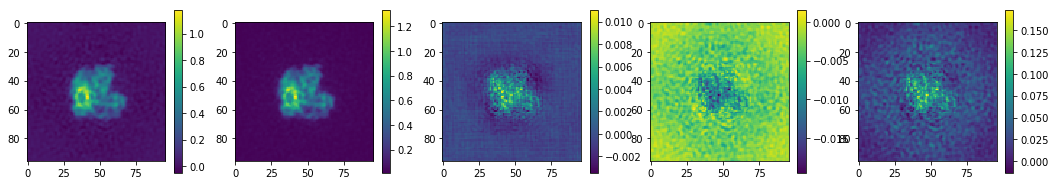

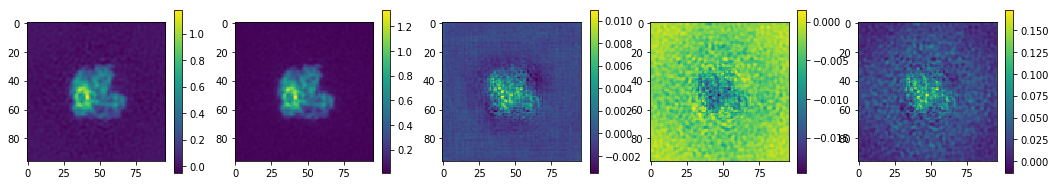

In [124]:
# reco = np.copy(ini) * 1e-9
tikhonov_kernel = kernel + 1e6
precondioner = np.abs(np.divide(1, tikhonov_kernel))
precondioner /= precondioner.max()
tikhonov = np.divide(complex_data, tikhonov_kernel)
reco = np.copy(tikhonov)

coordinate_change = get_coordinate_change(power=1.0, cutoff=1000.0)

# The scales produce gradients of order 1
ADVERSARIAL_SCALE=(96**(-0.5))
DATA_SCALE=1/(10*96**3)

IMAGING_SCALE=96

for k in range(70):
    STEP_SIZE=2.0 * 1 / np.sqrt(1 + k / 20)
    
    gradient = grad(reco)
    g1 = 0.3 * coordinate_change * gradient * ADVERSARIAL_SCALE
#     print(l2(gradient))
    g2 = DATA_SCALE*(np.multiply(reco, tikhonov_kernel) - complex_data)
    
    g = g1 + g2
#     reco = reco - STEP_SIZE * 0.02 * g
    reco = reco - STEP_SIZE * precondioner * g
    
    if 1:
        reco = np.fft.rfftn(np.maximum(0, np.fft.irfftn(reco)))
        
    #reco = reco - STEP_SIZE*(g1 + g2 + g3)
    if k%10==0:
        plt.figure(k, figsize=(18,3))
        plt.subplot(151)
        vis(IMAGING_SCALE*tikhonov)
        plt.colorbar()
        plt.subplot(152)
        vis(IMAGING_SCALE*reco)
        plt.colorbar()
        plt.subplot(153)
        vis(-IMAGING_SCALE*precondioner*g1)
        plt.colorbar()
        plt.subplot(154)
        vis(-IMAGING_SCALE*precondioner*g2)
        plt.colorbar()
        plt.subplot(155)
        vis(IMAGING_SCALE*(reco - tikhonov))
        plt.colorbar()
        plt.show()

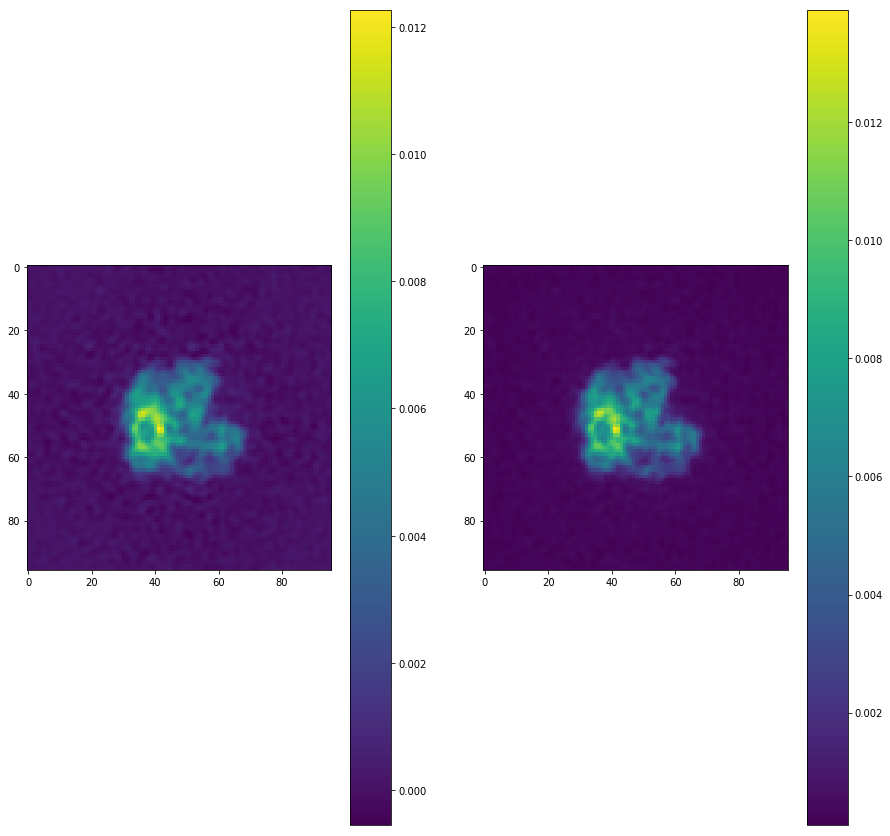

In [127]:
plt.figure(figsize=(15,15))
plt.subplot(121)
vis(tikhonov)
plt.colorbar()
plt.subplot(122)
vis(reco)
plt.colorbar()

In [64]:
print(l2_gt(irfft(tikhonov)))

0.664105
0.661289
0.649576
0.646866
0.642986
Final Registration Loss: 0.642426
Rotation: 
[[[ 0.9997153   0.01604979  0.01765689]
  [-0.01600708  0.9998686  -0.00255746]
  [-0.01769561  0.0022741   0.9998408 ]]]
Translation: 
[[[-0.00070153]
  [ 0.0008303 ]
  [ 0.00022864]]]
0.785039


l2(np.multiply(reco, kernel)-complex_data)

In [65]:
### evaluations
print(l2_gt(np.maximum(0,irfft(tikhonov))))

0.645879
0.660979
0.648816
0.639403
0.635643
Final Registration Loss: 0.634827
Rotation: 
[[[ 0.9998266   0.00567077  0.01773575]
  [-0.00579155  0.99996036  0.00676638]
  [-0.01769667 -0.00686792  0.9998198 ]]]
Translation: 
[[[ -1.68627466e-03]
  [  3.03500565e-06]
  [ -1.34268496e-03]]]
0.779847


In [69]:
print(l2_gt(irfft(reco)))

0.62222
0.637732
0.618354
0.613749
0.608502
Final Registration Loss: 0.607542
Rotation: 
[[[  9.99740124e-01   7.25433510e-03   2.16119494e-02]
  [ -7.24161556e-03   9.99973476e-01  -6.66736159e-04]
  [ -2.16162167e-02   5.10057434e-04   9.99766290e-01]]]
Translation: 
[[[-0.00013298]
  [ 0.00053504]
  [ 0.00010883]]]
0.76384


In [80]:
def evaluate(p, reg, cf):
    tikhonov_kernel = kernel + 1e6
    precondioner = np.abs(np.divide(1, tikhonov_kernel))
    precondioner /= precondioner.max()
    tikhonov = np.divide(complex_data, tikhonov_kernel)

    reco = np.copy(tikhonov)

    coordinate_change = get_coordinate_change(power=p, cutoff=cf)

    # The scales produce gradients of order 1
    ADVERSARIAL_SCALE=(96**(-0.5))
    DATA_SCALE=1/(10*96**3)

    IMAGING_SCALE=96

    for k in range(70):
        STEP_SIZE=2.0 * 1 / np.sqrt(1 + k / 20)

        g1 = reg * coordinate_change * grad(reco) * ADVERSARIAL_SCALE
        g2 = DATA_SCALE*(np.multiply(reco, tikhonov_kernel) - complex_data)

        g = g1 + g2
    #     reco = reco - STEP_SIZE * 0.02 * g
        reco = reco - STEP_SIZE * precondioner * g

        reco = np.fft.rfftn(np.maximum(0, np.fft.irfftn(reco)))
    
    msft = l2_gt(irfft(reco))
    return msft

All following results are on iterate 4!

In [74]:
regularizations = [0.3, 0.5, 0.75, 1, 1.5]
powers = [0.75, 1.0, 1.5, 2]
# results. Optimality at p=1, reg=0.5 at .705
r1

{'p: 0.75, Reg: 0.3': 0.73155415,
 'p: 0.75, Reg: 0.5': 0.79799616,
 'p: 0.75, Reg: 0.75': 0.86052632,
 'p: 0.75, Reg: 1': 0.85702205,
 'p: 0.75, Reg: 1.5': 0.97399729,
 'p: 1, Reg: 0.3': 0.70976192,
 'p: 1, Reg: 0.5': 0.7059319,
 'p: 1, Reg: 0.75': 0.7270363,
 'p: 1, Reg: 1': 0.76728475,
 'p: 1, Reg: 1.5': 0.81126386,
 'p: 1.5, Reg: 0.3': 0.72929412,
 'p: 1.5, Reg: 0.5': 0.7257297,
 'p: 1.5, Reg: 0.75': 0.72210777,
 'p: 1.5, Reg: 1': 0.71871287,
 'p: 1.5, Reg: 1.5': 0.71497619,
 'p: 2, Reg: 0.3': 0.73229289,
 'p: 2, Reg: 0.5': 0.7310012,
 'p: 2, Reg: 0.75': 0.73135072,
 'p: 2, Reg: 1': 0.73385245,
 'p: 2, Reg: 1.5': 0.74049693}

In [80]:
regularizations = [0.15, 0.2, 0.3, 0.5]
powers = [0.6, 0.8, 1.0]
# results. Optimality at p=.8, reg=0.2 at .705
r2

{'p: 0.6, Reg: 0.15': 0.72153503,
 'p: 0.6, Reg: 0.2': 0.75572312,
 'p: 0.6, Reg: 0.3': 0.79591483,
 'p: 0.6, Reg: 0.5': 0.85575384,
 'p: 0.8, Reg: 0.15': 0.70928323,
 'p: 0.8, Reg: 0.2': 0.7055673,
 'p: 0.8, Reg: 0.3': 0.71538812,
 'p: 0.8, Reg: 0.5': 0.77188319,
 'p: 1.0, Reg: 0.15': 0.72100562,
 'p: 1.0, Reg: 0.2': 0.71769202,
 'p: 1.0, Reg: 0.3': 0.70880616,
 'p: 1.0, Reg: 0.5': 0.70482206}

In [107]:
# Stability wrt to cutoffs
regularizations = [0.2, 0.5, 0.7]
cutoffs = [100.0, 333.3, 1000.0, 3333.3]
r3

{'Reg: 0.2, Cut: 100.0': 0.71575201,
 'Reg: 0.2, Cut: 333.3': 0.71636111,
 'Reg: 0.2, Cut: 1000.0': 0.71588922,
 'Reg: 0.2, Cut: 3333.3': 0.71606791,
 'Reg: 0.5, Cut: 100.0': 0.7053057,
 'Reg: 0.5, Cut: 333.3': 0.70481187,
 'Reg: 0.5, Cut: 1000.0': 0.70524955,
 'Reg: 0.5, Cut: 3333.3': 0.70499617,
 'Reg: 0.7, Cut: 100.0': 0.720052,
 'Reg: 0.7, Cut: 333.3': 0.71978509,
 'Reg: 0.7, Cut: 1000.0': 0.72044945,
 'Reg: 0.7, Cut: 3333.3': 0.71970564}

This result is in iterate 1

In [85]:
regularizations = [0.15, 0.2, 0.3, 0.5]
powers = [1.0]
r1

{'p: 1.0, Reg: 0.15': 0.76820123,
 'p: 1.0, Reg: 0.2': 0.76569796,
 'p: 1.0, Reg: 0.3': 0.7632485,
 'p: 1.0, Reg: 0.5': 0.77455413}

This result is in iterate 10

In [99]:
regularizations = [0.15, 0.2, 0.3, 0.5]
powers = [1.0]
r2

{'p: 1.0, Reg: 0.15': 0.6427111,
 'p: 1.0, Reg: 0.2': 0.63768804,
 'p: 1.0, Reg: 0.3': 0.62784439,
 'p: 1.0, Reg: 0.5': 0.61745161}

In [96]:
regularizations = [0.15, 0.2, 0.3, 0.5]
powers = [1.0]
results ={}
for p in powers:
    for reg in regularizations:
        res = evaluate(p, reg, 1000)
        print(res)
        results['p: {}, Reg: {}'.format(p, reg)]=res

1000
1.0
0.474871
0.43967
0.455513
0.43407
0.431828
Final Registration Loss: 0.428688
Rotation: 
[[[ 0.99950695  0.01245596  0.02882164]
  [-0.01229237  0.9999073  -0.00584595]
  [-0.02889178  0.00548878  0.9995675 ]]]
Translation: 
[[[-0.00101794]
  [ 0.00051996]
  [ 0.00054527]]]
0.642711
1000
1.0
0.466665
0.474819
0.45844
0.438752
0.422545
Final Registration Loss: 0.421731
Rotation: 
[[[ 0.99938613  0.00685727  0.0343563 ]
  [-0.00673555  0.9999706  -0.0036574 ]
  [-0.03438037  0.00342375  0.99940294]]]
Translation: 
[[[-0.00021221]
  [-0.00010546]
  [ 0.00012951]]]
0.637688
1000
1.0
0.454629
0.436739
0.448698
0.410028
0.409992
Final Registration Loss: 0.408261
Rotation: 
[[[ 0.9994587   0.00797318  0.03191959]
  [-0.0079189   0.99996704 -0.00182631]
  [-0.0319331   0.00157255  0.9994888 ]]]
Translation: 
[[[-0.0017854 ]
  [ 0.0004533 ]
  [-0.00058922]]]
0.627844
1000
1.0
0.446671
0.414635
0.437176
0.416929
0.397934
Final Registration Loss: 0.394032
Rotation: 
[[[ 0.999346    0.0043

In [97]:
r2 = results

In [159]:
regularizations = [0.3, 0.5, 0.7, 0.9]
results ={}
for reg in regularizations:
    res = evaluate(1, reg, cf=1000.0)
    results['Reg: {}'.format(reg)]=res

1000.0
1
0.4546
0.462431
0.439141
0.426015
0.411728
Final Registration Loss: 0.407939
Rotation: 
[[[ 0.9994113   0.01198165  0.03214845]
  [-0.01173617  0.9999006  -0.0078138 ]
  [-0.03223888  0.0074319   0.99945253]]]
Translation: 
[[[-0.00110071]
  [ 0.00149477]
  [ 0.00105813]]]
1000.0
1
0.446738
0.435898
0.418532
0.396236
0.397279
Final Registration Loss: 0.3921
Rotation: 
[[[ 0.99928683  0.01223695  0.03572132]
  [-0.01196577  0.9998981  -0.00779539]
  [-0.03581307  0.0073624   0.9993314 ]]]
Translation: 
[[[-0.00188265]
  [ 0.00060354]
  [ 0.00039839]]]
1000.0
1
0.459962
0.423212
0.419501
0.396572
0.389321
Final Registration Loss: 0.390019
Rotation: 
[[[  9.99372184e-01   8.56447127e-03   3.43783461e-02]
  [ -8.53352156e-03   9.99963045e-01  -1.04687922e-03]
  [ -3.43860500e-02   7.52853579e-04   9.99408305e-01]]]
Translation: 
[[[-0.00013507]
  [ 0.00198233]
  [ 0.00070772]]]
1000.0
1
0.498097
0.440448
0.40893
0.414428
0.406848
Final Registration Loss: 0.401979
Rotation: 
[[[ 0.

In [160]:
results

{'Reg: 0.3': 0.62762392,
 'Reg: 0.5': 0.61597013,
 'Reg: 0.7': 0.61476833,
 'Reg: 0.9': 0.62434083}